In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

## 1. 데이터 확인 및 분리

In [2]:
# 데이터 불러오기
data = pd.read_csv('clustering_data.csv')
data = data.drop('Unnamed: 0',axis=1)
data.head()

,CTY_NM,ratio,tot
0,강남구,117.501236,304
1,강동구,130.707905,201
2,강북구,255.741946,162
3,강서구,151.529412,325
4,관악구,232.544572,250


<AxesSubplot:xlabel='ratio', ylabel='tot'>

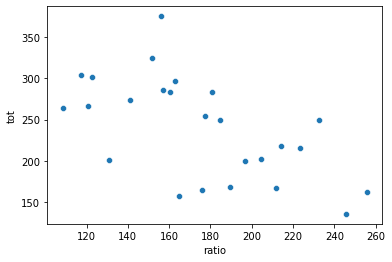

In [3]:
# 데이터 확인
sns.scatterplot(x='ratio',y='tot',data=data)

In [4]:
feature = data[['ratio','tot']]
name = data['CTY_NM']

## 2. DBSCAN 적용

https://todayisbetterthanyesterday.tistory.com/62 <br>
https://creatorjo.tistory.com/150?category=883823 <br>

### 1) 파라미터 임의 설정 후 군집 수 확인

In [5]:
model = DBSCAN(eps=5,min_samples=2)
model.fit(feature)
cluster = pd.DataFrame(model.labels_)
len(cluster.iloc[:,0].unique())

2

### 2) eps에 따라 나눠지는 군집 수 확인

<AxesSubplot:>

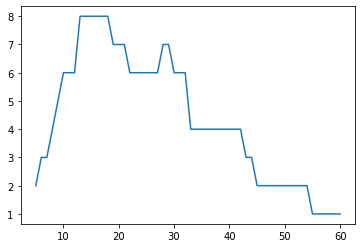

In [9]:
# min_samples = 2 고정

min_samples=2
result = []

# eps 적용 범위는 여러 값을 대입해 본 후 결정
# 최소값 = 처음으로 군집이 2개 이상 나뉘는 값
# 최대값 = 군집이 1개로 변하는 값 
for i in range(5,61,1): 
    model = DBSCAN(eps=i,min_samples=min_samples)
    model.fit(feature)
    labels = pd.DataFrame(model.labels_)
    result.append(len(labels.iloc[:,0].unique()))
    
plt.yticks(range(1,10,1))
sns.lineplot(x=range(5,61,1),y=result)

<AxesSubplot:>

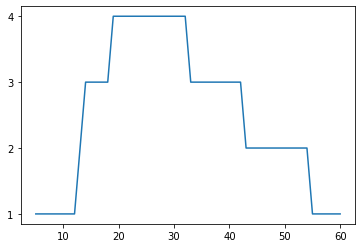

In [10]:
# min_samples =3 변경 

min_samples=3
result = []

for i in range(5,61,1): # 여러 값을 대입해 본 후 결정함
    model = DBSCAN(eps=i,min_samples=min_samples)
    model.fit(feature)
    labels = pd.DataFrame(model.labels_)
    result.append(len(labels.iloc[:,0].unique()))

plt.yticks(range(1,10,1))
sns.lineplot(x=range(5,61,1),y=result)

- 파라미터에 따라 성능이 크게 달라져, 임의로 정할 수 없다고 판단 <br>
- 일반적인 방법론을 활용한 후 수정하기로 결정

## 3. Heuristic방법론을 사용한 파라미터 설정

https://rfriend.tistory.com/588 <br>
https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

### 1) min-samples

In [11]:
# ln(n) 
import numpy as np
np.log(len(data))

3.2188758248682006

### 2) eps

In [21]:
# 데이터의 각 점과 선택된 MinPts 값의 평균 거리 계산 
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=3) 
neighbors_fit = neighbors.fit(feature)
distances,indices = neighbors_fit.kneighbors(feature)

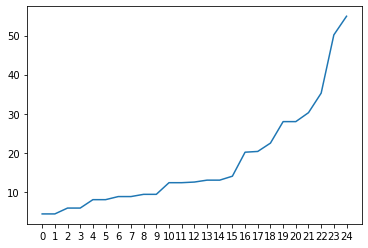

In [22]:
# 오름 차순 정렬 
distances = np.sort(distances,axis=0)
distances = distances[:,1]

plt.xticks(range(0,25,1))
plt.plot(distances)

- 일정한 증가 추세가 아니므로 눈에 띄는 점을 적용해보고 판단하기로 결정<br>
- 앞에서 군집 분류가 되지 않았던 5이하의 값은 제외<br>
- eps = 9,15,16,19,21,23 선택  

In [23]:
# 위에서 선택한 eps에 따라 나눠지는 군집 수 확인
min_samples = 3
eps_list = [9,15,16,19,21,23]


for e in eps_list:
    model = DBSCAN(eps=e,min_samples=min_samples)
    model.fit(feature)
    labels = pd.DataFrame(model.labels_)
    print("eps = {}일때, 군집의 수는 {}개\n".format(e,len(labels.iloc[:,0].unique())))

eps = 9일때, 군집의 수는 1개

eps = 15일때, 군집의 수는 3개

eps = 16일때, 군집의 수는 3개

eps = 19일때, 군집의 수는 4개

eps = 21일때, 군집의 수는 4개

eps = 23일때, 군집의 수는 4개



- 군집 수가 1개로 나타나는 eps=9는 제외<br>
- 군집이 같은 수로 나타나는 경우, 동일한 결과인지 확인 필요<br>
- 군집이 3개인 경우와 4개인 경우 어느 것이 적절한지 결정 필요

In [25]:
# 군집 3개
min_samples = 3
eps_list=[15,16]
result_3 = data.copy()

for e in eps_list:
    model = DBSCAN(eps=e,min_samples=min_samples)
    model.fit(feature)
    predict = pd.DataFrame(model.fit_predict(feature))
    predict.columns=["eps="+str(e)]
    result_3 = pd.concat([result_3,predict],axis=1)
    
result_3['Test'] = result_3['eps=15']==result_3['eps=16']
result_3

,CTY_NM,ratio,tot,eps=15,eps=16,Test
0,강남구,117.501236,304,-1,-1,True
1,강동구,130.707905,201,-1,-1,True
2,강북구,255.741946,162,-1,-1,True
3,강서구,151.529412,325,-1,-1,True
4,관악구,232.544572,250,-1,-1,True
5,광진구,164.941084,158,0,0,True
6,구로구,180.530203,283,-1,-1,True
7,금천구,211.962286,167,-1,-1,True
8,노원구,155.835207,375,-1,-1,True
9,도봉구,214.057018,218,-1,-1,True


In [38]:
# 군집 4개
min_samples = 3
eps_list=[19,21,23]
result_4 = data.copy()

for e in eps_list:
    model = DBSCAN(eps=e,min_samples=min_samples)
    model.fit(feature)
    predict = pd.DataFrame(model.fit_predict(feature))
    predict.columns=["eps="+str(e)]
    result_4 = pd.concat([result_4,predict],axis=1)
    
result_4['Test 19 and 21'] = result_4['eps=19']==result_4['eps=21']
result_4['Test 19 and 23'] = result_4['eps=19']==result_4['eps=23']
result_4['Test 21 and 23'] = result_4['eps=21']==result_4['eps=23']
result_4

,CTY_NM,ratio,tot,eps=19,eps=21,eps=23,Test 19 and 21,Test 19 and 23,Test 21 and 23
0,강남구,117.501236,304,-1,-1,-1,True,True,True
1,강동구,130.707905,201,-1,-1,-1,True,True,True
2,강북구,255.741946,162,-1,-1,-1,True,True,True
3,강서구,151.529412,325,-1,-1,-1,True,True,True
4,관악구,232.544572,250,-1,-1,-1,True,True,True
5,광진구,164.941084,158,1,1,2,True,False,False
6,구로구,180.530203,283,-1,2,0,False,False,False
7,금천구,211.962286,167,-1,-1,2,True,False,False
8,노원구,155.835207,375,-1,-1,-1,True,True,True
9,도봉구,214.057018,218,0,0,1,True,False,False


In [30]:
print(result_4['Test 19 and 21'].value_counts())
print(result_4['Test 19 and 23'].value_counts())
print(result_4['Test 21 and 23'].value_counts())

True     23
False     2
Name: Test 19 and 21, dtype: int64
False    15
True     10
Name: Test 19 and 23, dtype: int64
False    15
True     10
Name: Test 21 and 23, dtype: int64


- 3개의 군집으로 클러스터링한 결과는 동일<br>
- 3개의 군집 결과 확인 후 4개의 군집으로 클러스터링한 결과는 다른 지표로 비교해보기로 결정<br>

## 4. 결과 확인 및 비교

### 1) 군집 3개

<AxesSubplot:xlabel='ratio', ylabel='tot'>

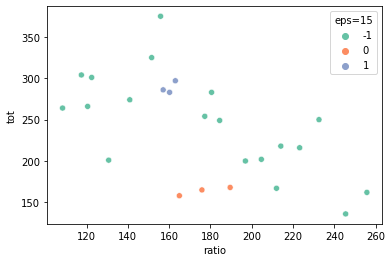

In [31]:
sns.scatterplot(x='ratio',y='tot',hue='eps=15',data=result_3,palette='Set2')

- 시각적으로 확인해봐도, 적절한 클러스터링 결과가 아니라고 판단됨 <br>
- 4개의 군집으로 분류한 결과 중 하나를 선택하여 사용하기로 결정

### 2) 군집 4개

- 3개의 모델(eps=19,21,23)이 모두 차이를 보이므로, 3개의 모델에 대해서 실루엣 계수를 판단

In [37]:
from sklearn.metrics.cluster import silhouette_score

min_samples = 3
eps_list=[19,21,23]

for e in eps_list:
    model = DBSCAN(eps=e,min_samples=min_samples)
    model.fit(feature)
    labels = model.labels_
    score = silhouette_score(feature,labels)
    print("eps={}일 때, Silhouette Coefficient : {}".format(e,score))

eps=19일 때, Silhouette Coefficient : -0.022658739316918683
eps=21일 때, Silhouette Coefficient : 0.06737140403391395
eps=23일 때, Silhouette Coefficient : 0.147869248472764


- 실루엣 계수가 그나마 높은 eps=23을 최종적으로 결정

<AxesSubplot:xlabel='ratio', ylabel='tot'>

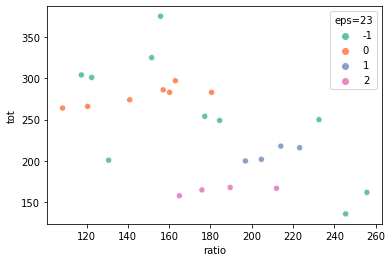

In [39]:
sns.scatterplot(x='ratio',y='tot',hue='eps=23',data=result_4,palette='Set2')

## 5. 최종 군집

In [40]:
data['cluster'] = result_4['eps=23']

In [41]:
# 군집 1
cluster1 = data[data['cluster']==-1]
print(len(cluster1))
cluster1

10


,CTY_NM,ratio,tot,cluster
0,강남구,117.501236,304,-1
1,강동구,130.707905,201,-1
2,강북구,255.741946,162,-1
3,강서구,151.529412,325,-1
4,관악구,232.544572,250,-1
8,노원구,155.835207,375,-1
11,동작구,177.251917,254,-1
17,송파구,122.487458,301,-1
21,은평구,184.450518,249,-1
23,중구,245.438487,136,-1


In [42]:
# 군집 2
cluster2 = data[data['cluster']==0]
print(len(cluster2))
cluster2

7


,CTY_NM,ratio,tot,cluster
6,구로구,180.530203,283,0
12,마포구,140.931947,274,0
14,서초구,108.378422,264,0
15,성동구,157.095413,286,0
16,성북구,160.204750,283,0
18,양천구,120.534893,266,0
19,영등포구,162.996595,297,0


In [43]:
# 군집 3
cluster3 = data[data['cluster']==1]
print(len(cluster3))
cluster3

4


,CTY_NM,ratio,tot,cluster
9,도봉구,214.057018,218,1
10,동대문구,196.919653,200,1
22,종로구,223.176595,216,1
24,중랑구,204.636419,202,1


In [44]:
# 군집 4
cluster4 = data[data['cluster']==2]
print(len(cluster4))
cluster4

4


,CTY_NM,ratio,tot,cluster
5,광진구,164.941084,158,2
7,금천구,211.962286,167,2
13,서대문구,175.863324,165,2
20,용산구,189.524891,168,2
